# Customer Sentiment

## Business Question

Create a model to determine the sentiment of a customer based on his or her tweet.

In [857]:
# importing packages

import numpy as np
import pandas as pd
from collections import defaultdict

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

### Twitter Data

The dataset contained 9093 tweets, as well as determinations of what type of emotional sentiment--positive or negative--each tweet might have expressed.  If there was an emotional angle to a tweet, the brand or product that emotion was directed toward was also included in the data.

In [858]:
corpus = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')

In [859]:
corpus.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [860]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


## Data Cleaning

In [861]:
# dropping the 1 row with a null tweet

corpus = corpus.dropna(subset = ['tweet_text'])
corpus = corpus.reset_index(drop=True)

In [862]:
# renaming long column names

corpus.rename(columns = {'emotion_in_tweet_is_directed_at': 'emotion_directed_at',
                         'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion_type'}, inplace=True)

In [863]:
corpus['emotion_type'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion_type, dtype: int64

In [864]:
corpus['emotion_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_directed_at, dtype: int64

## Feature Engineering

In order to determine which tweets are directed toward Apple, we create a new numerical column to identify whether the brand is Apple or not.

In [865]:
# create brand lists that include the appropriate brands and products

Apple = ['iPad', 'Apple', 'iPad or iPhone App', 'iPhone', 'Other Apple product or service']


In [866]:
# create the numerical categories for brands

def target_brand(emotion_directed_at):
    if emotion_directed_at in Apple:
        return 1
    else:
        return 0

In [867]:
# add the new column

corpus['target_brand'] = corpus['emotion_directed_at'].apply(target_brand)

In [868]:
corpus['target_brand'].value_counts()

0    6683
1    2409
Name: target_brand, dtype: int64

In a new numerical column, we categorize the type of emotion in the tweet as positive, negative, or neutral.  Neutral includes instances where there was no emotion toward a brand or product found or where the evaluator couldn't tell.

In [869]:
# create groups of emotion types

Positive = ['Positive emotion']
Negative = ['Negative emotion']
Neutral = ['No emotion toward brand or product', "I can't tell"]

In [870]:
# create the numerical categories for emotion types

def target_emotion(emotion_type):
    if emotion_type in Positive:
        return 0
    if emotion_type in Negative:
        return 1
    if emotion_type in Neutral:
        return 2
    else:
        return 3

In [871]:
# add the new column

corpus['target_emotion'] = corpus['emotion_type'].apply(target_emotion)

In [1173]:
corpus['target_emotion'].value_counts()

2    0.609767
0    0.327541
1    0.062692
Name: target_emotion, dtype: float64

In [873]:
# create new dataframe with tweets directed at Apple

df_apple = corpus[(corpus['target_brand'] == 1) & (corpus['target_emotion'] < 2)]
df_apple = df_apple.reset_index(drop=True)
df_apple.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   tweet_text           2337 non-null   object
 1   emotion_directed_at  2337 non-null   object
 2   emotion_type         2337 non-null   object
 3   target_brand         2337 non-null   int64 
 4   target_emotion       2337 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 91.4+ KB


In [1113]:
df_apple['target_emotion'].value_counts(normalize=True)

0    0.833975
1    0.166025
Name: target_emotion, dtype: float64

We can now remove the columns we don't need and work with the tweets and target emotions going forward.

In [875]:
df_apple = df_apple.drop(['emotion_directed_at', 'emotion_type', 'target_brand'], axis =1)

In [1095]:
# sanity check

df_apple.head()

,tweet_text,target_emotion,product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,1,iphone
1,@jessedee Know about @fludapp ? Awesome iPad/i...,0,ipad
2,@swonderlin Can not wait for #iPad 2 also. The...,0,ipad
3,@sxsw I hope this year's festival isn't as cra...,1,iphone
4,Beautifully smart and simple idea RT @madebyma...,0,ipad


In [1107]:
# create csv file of our filtered data set

df_apple.to_csv('Apple_tweets.csv')

## Natural Language Processing (NLP)

We start with a train test split, placing 80% of the data in the train set and 20% in test.  The tweets are the independent variable, and the target is the emotion.  A negative emotion is 1, positive emotion is 0.

In [877]:
X = df_apple['tweet_text']
y = df_apple['target_emotion']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

### NLP Pre-processing

In [878]:
# adjust the nltk list of stopwords

sw = list(set(stopwords.words('english')) - {'not'})
sw.extend(['sxsw', 'austin', 'link', 'rt', 'among', 'mention'])

In [879]:
# transform the tags to parts of speech tags for the WordNetLemmatizer

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [880]:
# use function to handle preprocessing steps

def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    # print(doc)
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [881]:
token_docs = [doc_preparer(doc, sw) for doc in X_train]

In [882]:
print(len(token_docs), len(X_train), len(y_train))

1869 1869 1869


In [883]:
# Check for missing values in X_train
missing_values_X_train = [idx for idx, doc in enumerate(X_train) if pd.isnull(doc)]
print(f"Number of missing values in X_train: {len(missing_values_X_train)}")

# Check for missing values in y_train
missing_values_y_train = [idx for idx, label in enumerate(y_train) if pd.isnull(label)]
print(f"Number of missing values in y_train: {len(missing_values_y_train)}")

Number of missing values in X_train: 0
Number of missing values in y_train: 0


In [1060]:
X_train

1573    RT @mention Hey, you lucky dogs at #SXSW with ...
65      I went to #sxswi and all I won was this lousy ...
1251    LOL, I don't see a single PC user around meÛÓ...
353     Attending TV + New Media = Formula for Success...
700     Download Daily Grape  - a new app from @mentio...
                              ...                        
1638    RT @mention Look everyone! Zomg @mention got a...
1095    @mention just got me an iPad from #SXSW Apple ...
1130    @mention Last but not least  get a copy of Stu...
1294    Well having the iPad has really been the perfe...
860     holy smokes, ipad2 replacing my flip cam as de...
Name: tweet_text, Length: 1869, dtype: object

In [1059]:
token_docs

['hey lucky dog ipads check holler gram app',
 'go sxswi lousy ipad',
 'lol see single pc user around macbooks ipads web devs definitely apple folk apple',
 'attend tv new medium formula success see lot ipad around',
 'download daily grape new app iphone take wine shop',
 'security guard enjoy ipad apple store ipad',
 'yup ipad envy roof thanks every person',
 'hope everyone awesome weekend know give away great apple prize',
 'get turkey random apple fan buy lunch everyone line popup apple store ipad cc',
 'hate type ipad yeah ken calhoun man real deal bring laptop sun',
 'video first ipad unboxing outside apple store come soon find decent wifi',
 'take major south korean director get make movie entirely iphone',
 'last day fastcompanygrille come last day iphone makery zazzlesxsw',
 'cool update npr music iphone app song info song amp live video streaming time',
 'ungrateful bc much shit play turn shit iphone',
 'really amaze see many people put apple note app ipad',
 'realize still pa

In [1058]:
pd.Series(token_docs).explode()

0               hey lucky dog ipads check holler gram app
1                                     go sxswi lousy ipad
2       lol see single pc user around macbooks ipads w...
3       attend tv new medium formula success see lot i...
4       download daily grape new app iphone take wine ...
                              ...                        
1864                look everyone zomg get ipad first day
1865                      get ipad apple store thank much
1866    last not least get copy stupid game plus iphon...
1867                      well ipad really perfect device
1868    holy smoke ipad replace flip cam default video...
Length: 1869, dtype: object

### NLP Feature Engineering

In [885]:
# Secondary train-test split to build our best model
X_t, X_val, y_t, y_val = train_test_split(token_docs,
                                          y_train,
                                          test_size=0.2,
                                          random_state=42)

First, we try a Count Vectorizer to get the counts of tokens in each of the tweets.

In [886]:
#cv = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw, analyzer='word')
#X_cv = cv.fit_transform(df_apple.tweet_text)

#df_cv = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names_out())

#df_cv

In [1046]:
# instantiate vectorizer and fit_transform it on the training set

cv = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw, analyzer='word')

X_t_cv = cv.fit_transform(X_t)
X_t_cv = pd.DataFrame.sparse.from_spmatrix(X_t_cv)
X_t_cv.columns = sorted(cv.vocabulary_)
X_t_cv.set_index(y_t.index, inplace=True)

In [888]:
X_t_cv

,aapl,abandon,aber,able,absolutely,abt,acceptable,access,accessibility,accessible,...,zazzlsxsw,zelda,zeldman,zero,zimride,zms,zombie,zomg,zone,zzzs
1077,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
389,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1913,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
243,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1900,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1880,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1070,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1047]:
# transform vectorizer on the validation set

X_val_cv = cv.transform(X_val)
X_val_cv = pd.DataFrame.sparse.from_spmatrix(X_val_cv)
X_val_cv.columns = sorted(cv.vocabulary_)
X_val_cv.set_index(y_val.index, inplace=True)

In [890]:
X_val_cv

,aapl,abandon,aber,able,absolutely,abt,acceptable,access,accessibility,accessible,...,zazzlsxsw,zelda,zeldman,zero,zimride,zms,zombie,zomg,zone,zzzs
202,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1774,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
594,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
893,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
310,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
934,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
704,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1160]:
neg_tweets = df_apple[df_apple['target_emotion'] == 1]
neg_tweets = neg_tweets.reset_index(drop=True)
neg_tweets

,tweet_text,target_emotion,product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,1,iphone
1,@sxsw I hope this year's festival isn't as cra...,1,iphone
2,I just noticed DST is coming this weekend. How...,1,iphone
3,attending @mention iPad design headaches #sxsw...,1,ipad
4,What !?!? @mention #SXSW does not provide iPh...,1,iphone
...,...,...,...
383,If there was a popup store in Austin that sold...,1,iphone
384,#iPad #news #apps not popular with the #kids. ...,1,ipad
385,Hmmm...Taxi Magic on iPhone does not appear to...,1,iphone
386,I think my effing hubby is in line for an #iPa...,1,ipad


In [1172]:
neg_tweets.tweet_text[377]

'If you have an iPad DO NOT upgrade to the newest iOS yet, TweetDeck is very unstable on it #nten #11ntc #sxsw #sxswi'

In [1117]:
neg_tweets_token = [doc_preparer(doc, sw) for doc in neg_tweets['tweet_text']]

In [1119]:
neg_token_cv = cv.fit_transform(neg_tweets_token)
neg_token_cv = pd.DataFrame.sparse.from_spmatrix(neg_token_cv)
neg_token_cv.columns = sorted(cv.vocabulary_)
#neg_token_cv.set_index(y_t.index, inplace=True)
neg_token_cv

,abacus,abandon,abt,acc,acerbic,across,action,activate,actually,ad,...,yes,yesterday,yet,yonkers,york,z,zelda,zeldman,zone,zzzs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
384,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1154]:
type(neg_word_list)

list

In [1155]:
neg_word_list = list(cv.get_feature_names_out())

#neg_word_list = list(map(lambda x: 'app' if x == 'apps' else x, neg_word_list))
#neg_word_list = list(map(lambda x: 'app' if x == 'apps' else x, neg_word_list))

for x in neg_word_list:
    if x == 'apps':
        neg_word_list.remove(x)

neg_word_count = neg_token_cv.sum(axis=0)
neg_word_dict = dict(zip(neg_word_list, neg_word_count))

#neg_word_dict['app'] = neg_word_dict['apps']
#del neg_word_dict['apps']

sorted_neg_word_dict = dict(sorted(neg_word_dict.items(), key=lambda item: item[1], reverse=True)[:25])
sorted_neg_word_dict

{'ipaddesignheadaches': 196,
 'iphones': 152,
 'apple': 116,
 'quotable': 115,
 'app': 47,
 'note': 45,
 'straight': 43,
 'likely': 35,
 'giant': 31,
 'god': 26,
 'designer': 25,
 'area': 24,
 'news': 24,
 'perhaps': 24,
 'amp': 20,
 'listen': 20,
 'loose': 19,
 'neither': 19,
 'ooing': 19,
 'thinking': 19,
 'commandeered': 18,
 'talk': 18,
 'batterykiller': 17,
 'daylight': 17,
 'timechange': 17}

In [891]:
#word_list = cv.get_feature_names_out()
#word_count = X_t_cv.toarray().sum(axis=0)
#word_dict = dict(zip(word_list, word_count))
#sorted_word_dict = dict(sorted(word_dict.items(), key=lambda item: item[1], reverse=True)[:10])
#sorted_word_dict

In [1130]:
word_count_df = pd.DataFrame(sorted_neg_word_dict.items(), columns=['word', 'weight'])
cols = word_count_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
word_count_df = word_count_df[cols]
word_count_df

,weight,word
0,196,ipad
1,152,iphone
2,116,apple
3,115,quot
4,47,app
5,45,not
6,43,store
7,35,like
8,31,get
9,26,go


In [1131]:
word_count_df.to_csv('negative_word_count.csv')

In [892]:
from collections import Counter
frequency_distribution = Counter(sorted_word_dict)
print(frequency_distribution)

Counter({'ipad': 847, 'apple': 610, 'iphone': 425, 'store': 338, 'app': 228, 'quot': 208, 'get': 153, 'new': 151, 'pop': 137, 'open': 106})


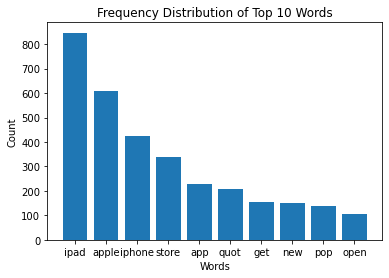

In [963]:
keys, values = zip(*frequency_distribution.items())

plt.bar(keys, values)
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Frequency Distribution of Top 10 Words')
plt.show();

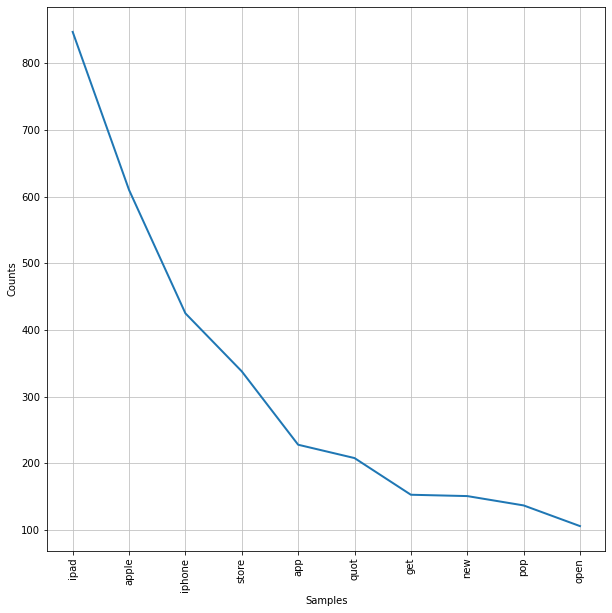

In [964]:
fdist = FreqDist(sorted_word_dict)
plt.figure(figsize=(10, 10))
fdist.plot(30);

We also want to try the TF-IDF Vectorizer to learn how important the words are in each tweet.

In [971]:
tf = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw, analyzer='word')
X_tf = tf.fit_transform(corpus.tweet_text)

df_tf = pd.DataFrame(X_tf.toarray(), columns=tf.get_feature_names_out())
df_tf.head()

,aapl,aaron,aarpbulletin,ab,abacus,abandoned,abba,abc,aber,abilities,...,zms,zomb,zombie,zombies,zomg,zone,zoom,zuckerberg,zynga,zzzs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [972]:
df_tf.iloc[313].sort_values(ascending=False)[:10]

electricnews    0.483129
slate           0.483129
safari          0.426796
traffic         0.329519
much            0.301562
see             0.241643
mobile          0.221784
app             0.177340
ipad            0.111655
forced          0.000000
Name: 313, dtype: float64

In [897]:
tfidf_dict = tf.vocabulary_
#{k: v for k, v in sorted(tf_values.items(), key = lambda item: item[1], reverse=True)}
sorted_tfidf_dict = dict(sorted(tfidf_dict.items(), key=lambda item: item[1], reverse=True))
print("Sorted TF-IDF Dictionary:", sorted_tfidf_dict)

Sorted TF-IDF Dictionary: {'zynga facebook': 18199, 'zynga': 18198, 'zuckerberg quot': 18197, 'zuckerberg': 18196, 'zoom': 18195, 'zone right': 18194, 'zone': 18193, 'zomg got': 18192, 'zomg': 18191, 'zombies like': 18190, 'zombies': 18189, 'zombie codes': 18188, 'zombie': 18187, 'zomb': 18186, 'zms': 18185, 'zlf': 18184, 'zip': 18183, 'zinio online': 18182, 'zinio': 18181, 'zing': 18180, 'zgd': 18179, 'zero': 18178, 'zelda': 18177, 'zeiger': 18176, 'ze frank': 18175, 'ze': 18174, 'zazzlsxsw get': 18173, 'zazzlsxsw': 18172, 'zazzlesxsw sxswi': 18171, 'zazzlesxsw': 18170, 'zazzle officially': 18169, 'zazzle ipad': 18168, 'zazzle gearing': 18167, 'zazzle': 18166, 'zappos likeability': 18165, 'zappos amp': 18164, 'zappos': 18163, 'zap': 18162, 'zaggle showed': 18161, 'zaggle': 18160, 'zaarlyiscoming winning': 18159, 'zaarlyiscoming': 18158, 'zaarly referrals': 18157, 'zaarly': 18156, 'z come': 18155, 'z': 18154, 'yur ipad': 18153, 'yur': 18152, 'yup': 18151, 'yum': 18150, 'yrs time': 1814

## Modeling

We will build a baseline model with a Multinomial Naive Bayes classifier.

In [1048]:
# create a pipeline to vectorize and run Multinomial Naive Bayes model

pipe_mnb = Pipeline([('cv', cv), ('mnb', MultinomialNB(alpha=0.1))])

In [1049]:
# fit the pipeline on the train set

pipe_mnb.fit(X_t, y_t)

Pipeline(steps=[('cv',
                 CountVectorizer(stop_words=["isn't", 'wasn', 'at', 'to',
                                             'having', 'once', 'with', 'o',
                                             'has', 'there', 'by', 's', 'below',
                                             'while', 'himself', 'she', 'had',
                                             'why', 'than', 'needn', 'when',
                                             'does', 'from', 'only', 'don',
                                             'doing', 'haven', "couldn't",
                                             'mustn', 'do', ...],
                                 token_pattern="([a-zA-Z]+(?:'[a-z]+)?)")),
                ('mnb', MultinomialNB(alpha=0.1))])

In [1050]:
# run cross validation

cross_val_score(pipe_mnb, X_t, y_t, cv=10)

array([0.84666667, 0.82      , 0.80666667, 0.84666667, 0.82666667,
       0.87919463, 0.85234899, 0.83892617, 0.87919463, 0.86577181])

In [1051]:
# make predictions for y

y_hat = pipe_mnb.predict(X_val)

In [1052]:
# metrics for baseline model

accuracy = accuracy_score(y_val, y_hat)
classification_rep = classification_report(y_val, y_hat)
conf_matrix = confusion_matrix(y_val, y_hat)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:f}")
print("\nClassification Report:")
print(classification_rep)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.898396

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       314
           1       0.71      0.62      0.66        60

    accuracy                           0.90       374
   macro avg       0.82      0.78      0.80       374
weighted avg       0.89      0.90      0.90       374


Confusion Matrix:
[[299  15]
 [ 23  37]]


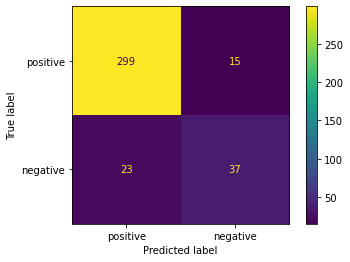

In [977]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['positive', 'negative'])
cm_display.plot()
plt.show()

We use GridSearch CV to adjust some hyperparameters to look for a better model.

In [994]:
# select parameters for ngrams, max features, and Laplace smoothing

params = {'cv__ngram_range': [(1, 1), (2, 2), (1, 2)],
          'cv__max_features': [5, 10, 15],
          'mnb__alpha': [0.1, 1, 10]}

gs = GridSearchCV(estimator=pipe_mnb,
                  param_grid = params,
                  cv=10)

In [995]:
gs.fit(X_t, y_t)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(stop_words=["isn't",
                                                                    'wasn',
                                                                    'at', 'to',
                                                                    'having',
                                                                    'once',
                                                                    'with', 'o',
                                                                    'has',
                                                                    'there',
                                                                    'by', 's',
                                                                    'below',
                                                                    'while',
                                                                    'himself',
                                                                    'she',
                                                                    'had',
                                                                    'why',
                                                                    'than',
                                                                    'needn',
                                                                    'when',
                                                                    'does',
                                                                    'from',
                                                                    'only',
                                                                    'don',
                                                                    'doing',
                                                                    'haven',
                                                                    "couldn't",
                                                                    'mustn',
                                                                    'do', ...],
                                                        token_pattern="([a-zA-Z]+(?:'[a-z]+)?)")),
                                       ('mnb', MultinomialNB(alpha=0.1))]),
             param_grid={'cv__max_features': [5, 10, 15],
                         'cv__ngram_range': [(1, 1), (2, 2), (1, 2)],
                         'mnb__alpha': [0.1, 1, 10]})

In [996]:
gs.best_params_

{'cv__max_features': 5, 'cv__ngram_range': (1, 1), 'mnb__alpha': 0.1}

In [997]:
gs.cv_results_['mean_test_score'].max()

0.8240850111856822

In [982]:
# set up a pipeline with TF-IDF vectorization and Multinomial Naive Bayes

pipe_mnb_tf = Pipeline([('tf', tf), ('mnb', MultinomialNB())])

In [983]:
# fit the pipeline on the train set

pipe_mnb_tf.fit(X_t, y_t)

Pipeline(steps=[('tf',
                 TfidfVectorizer(stop_words=["isn't", 'wasn', 'at', 'to',
                                             'having', 'once', 'with', 'o',
                                             'has', 'there', 'by', 's', 'below',
                                             'while', 'himself', 'she', 'had',
                                             'why', 'than', 'needn', 'when',
                                             'does', 'from', 'only', 'don',
                                             'doing', 'haven', "couldn't",
                                             'mustn', 'do', ...],
                                 token_pattern="([a-zA-Z]+(?:'[a-z]+)?)")),
                ('mnb', MultinomialNB())])

In [1005]:
# run cross validation

cross_val_score(pipe_mnb_tf, X_t, y_t, cv=10)

array([0.83333333, 0.82666667, 0.82666667, 0.83333333, 0.82      ,
       0.83221477, 0.82550336, 0.83892617, 0.82550336, 0.83892617])

In [1006]:
# make predictions for y

y_hat_tf = pipe_mnb_tf.predict(X_val)

In [1007]:
# metrics for TF-IDF model

accuracy = accuracy_score(y_val, y_hat_tf)
classification_rep = classification_report(y_val, y_hat_tf)
conf_matrix = confusion_matrix(y_val, y_hat_tf)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:f}")
print("\nClassification Report:")
print(classification_rep)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.844920

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.92       314
           1       1.00      0.03      0.06        60

    accuracy                           0.84       374
   macro avg       0.92      0.52      0.49       374
weighted avg       0.87      0.84      0.78       374


Confusion Matrix:
[[314   0]
 [ 58   2]]


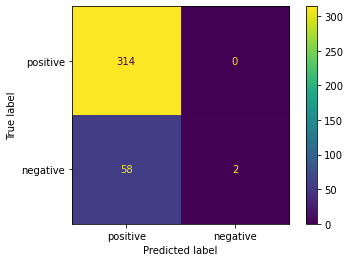

In [986]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['positive', 'negative'])
cm_display.plot()
plt.show()

In [914]:
# Look at # of words per tweet (like # of sentences in nlp lab)??
# if tweet contains product names?
# Try different max_features in vectorizer, max_df, min_df
# more ngrams
# Tf-Idf
# balance the targets

In [915]:
type(X_t_cv)

pandas.core.frame.DataFrame

In [916]:
def word_count(df):
    for i in range(df.shape[1]):
        words = {df.keys():df.sum(axis=1)}
    return words    

In [917]:
#A = X_t_cv.apply(word_count(X_t_cv))

Random Forest classifier.

In [1011]:
# Initiate the random forest, fit it on the train set and predict y

rf = RandomForestClassifier(n_estimators=1000, max_features=5, max_depth=5)
rf.fit(X_t_cv, y_t)
y_hat_rf = rf.predict(X_val_cv)


In [1012]:
# metrics for random forest

accuracy = accuracy_score(y_val, y_hat_rf)
classification_rep = classification_report(y_val, y_hat_rf)
conf_matrix = confusion_matrix(y_val, y_hat_rf)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:f}")
print("\nClassification Report:")
print(classification_rep)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.839572

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       314
           1       0.00      0.00      0.00        60

    accuracy                           0.84       374
   macro avg       0.42      0.50      0.46       374
weighted avg       0.70      0.84      0.77       374


Confusion Matrix:
[[314   0]
 [ 60   0]]


c:\Users\dangr\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dangr\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dangr\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The random forest seemed to only predict positive emotion.    

We'll use the feature importance from the random forest to focus on the top 10 features for another Multinomial Naive Bayes model.

In [1013]:
# Feature Importances 
feat_import = {name: score 
                   for name, score 
                       in zip(X_t_cv.columns, rf.feature_importances_)
}
feat_import

{'aapl': 0.0003549736291124458,
 'abandon': 0.0016191206718721015,
 'aber': 0.0,
 'able': 0.00011792621513573401,
 'absolutely': 0.0,
 'abt': 0.0004992573380812869,
 'acceptable': 9.431694126455662e-05,
 'access': 5.3639019807900795e-05,
 'accessibility': 0.0,
 'accessible': 4.3322195794370825e-05,
 'accessory': 6.415902341590307e-05,
 'accommodate': 4.393647282942337e-08,
 'accordion': 0.0,
 'acerbic': 0.00047276648926094307,
 'acquire': 0.0003177545582053699,
 'across': 0.0004961233966598399,
 'acrosse': 2.544092868607421e-05,
 'action': 0.0004639273967317821,
 'activity': 0.0,
 'actor': 0.0,
 'actsofsharing': 5.556598169478117e-05,
 'actual': 0.0,
 'actually': 0.0005127664026775262,
 'ad': 0.001384958158834828,
 'adam': 0.0,
 'add': 0.00011841304385423264,
 'added': 0.0,
 'addict': 3.150743025797369e-05,
 'addictedtotheinterwebs': 0.0,
 'additional': 0.0,
 'admission': 0.0,
 'admit': 0.0005788461863396654,
 'ado': 0.0,
 'adopter': 3.677330277175135e-05,
 'adoption': 3.47262558650432

In [1014]:
# Assuming feat_import is your dictionary of feature importances
max_feature = max(feat_import, key=lambda k: feat_import[k])

# Print the feature with the greatest importance and its score
print(f"The feature with the greatest importance is: {max_feature}")
print(f"Importance Score: {feat_import[max_feature]}")

The feature with the greatest importance is: iphone
Importance Score: 0.008308994485173289


In [1015]:
# Assuming feat_import is your dictionary of feature importances
top_features = sorted(feat_import.items(), key=lambda x: x[1], reverse=True)[:10]

# Print the top 10 features and their scores
print("Top 10 features:")
for feature, importance in top_features:
    print(f"{feature}: {importance}")

Top 10 features:
iphone: 0.008308994485173289
fail: 0.007717379004981748
ipad: 0.006938257455774961
fade: 0.0066346519632583464
kara: 0.005954490205881215
fascist: 0.005837660972633302
store: 0.005540695973581849
hate: 0.005337724737703744
fuck: 0.004729306782914456
sun: 0.004678042910039624


In [1016]:
# Assuming top_features is a list of your top feature names
top_feature_names = [feature for feature, _ in top_features]

# Create a subset of your data with only the top features
X_subset = X_t_cv[top_feature_names].values  # Use .values to get the underlying NumPy array

# Convert X_subset to a DataFrame
X_subset_df = pd.DataFrame(X_subset, columns=top_feature_names)

# Include the original DataFrame along with the top features
X_t_cv.reset_index(drop=True, inplace=True)
X_subset_df.reset_index(drop=True, inplace=True)
X_original_and_top_features = pd.concat([X_t_cv, X_subset_df], axis=1)

# predict 'target_emotion'
y_subset_df = pd.DataFrame(y_t).values  # Use .values to get the underlying NumPy array

# Ensure X and y have the same number of samples
min_samples = min(X_original_and_top_features.shape[0], y_subset_df.shape[0])
X_original_and_top_features = X_original_and_top_features.iloc[:min_samples, :]
y_subset_df = y_subset_df[:min_samples]

# Split the data into training and testing sets
X_t_top_feat, X_val_top_feat, y_t_top_feat, y_val_top_feat = train_test_split(X_original_and_top_features, y_subset_df, test_size=0.2, random_state=42)

# Train a Multinomial Naive Bayes classifier
mnb_top_feat = MultinomialNB()
mnb_top_feat.fit(X_t_top_feat, y_t_top_feat.ravel())

c:\Users\dangr\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:785: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


MultinomialNB()

In [1018]:
#top_feat_cross_val = cross_val_score(mnb_top_feat, X_t_top_feat, y_t_top_feat)
#top_feat_cross_val

In [1019]:
# Make predictions on the test set
y_hat_top_feat = mnb_top_feat.predict(X_val_top_feat)

accuracy = accuracy_score(y_val_top_feat, y_hat_top_feat)
classification_rep = classification_report(y_val_top_feat, y_hat_top_feat)
cm_top_feat = confusion_matrix(y_val_top_feat, y_hat_top_feat)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:f}")
print("\nClassification Report:")
print(classification_rep)

Accuracy: 0.849498

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       243
           1       0.63      0.48      0.55        56

    accuracy                           0.85       299
   macro avg       0.76      0.71      0.73       299
weighted avg       0.84      0.85      0.84       299



c:\Users\dangr\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:785: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


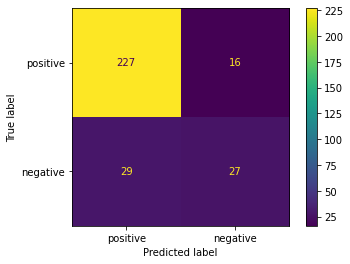

In [1020]:
cm_top_feat_disp = ConfusionMatrixDisplay(confusion_matrix=cm_top_feat, display_labels=['positive', 'negative'])
cm_top_feat_disp.plot()
plt.show()

In [1021]:
# look back to baseline results to compare

accuracy = accuracy_score(y_val, y_hat)
classification_rep = classification_report(y_val, y_hat)
conf_matrix = confusion_matrix(y_val, y_hat)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:f}")
print("\nClassification Report:")
print(classification_rep)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.898396

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       314
           1       0.71      0.62      0.66        60

    accuracy                           0.90       374
   macro avg       0.82      0.78      0.80       374
weighted avg       0.89      0.90      0.90       374


Confusion Matrix:
[[299  15]
 [ 23  37]]


In [1104]:
#Visualization of Postive and Negative Emottion Tweets for Apple Products

df_apple['product'] = ''
for i in range(len(df_apple['tweet_text'])):
    string = df_apple['tweet_text'][i]

    if isinstance(string, str):
        if 'ipad' in string.lower():
            df_apple.at[i, 'product'] = 'ipad'
        elif 'iphone' in string.lower():
            df_apple.at[i, 'product'] = 'iphone'
        elif 'apple' in string.lower():
            df_apple.at[i, 'product'] = 'apple'
        else:
            df_apple.at[i, 'product'] = 'none'
                

In [1097]:
df_apple

,tweet_text,target_emotion,product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,1,iphone
1,@jessedee Know about @fludapp ? Awesome iPad/i...,0,ipad
2,@swonderlin Can not wait for #iPad 2 also. The...,0,ipad
3,@sxsw I hope this year's festival isn't as cra...,1,iphone
4,Beautifully smart and simple idea RT @madebyma...,0,ipad
...,...,...,...
2332,@mention your iPhone 4 cases are Rad and Ready...,0,iphone
2333,@mention your PR guy just convinced me to swit...,0,iphone
2334,&quot;papyrus...sort of like the ipad&quot; - ...,0,ipad
2335,I've always used Camera+ for my iPhone b/c it ...,0,ipad


In [1174]:
df_apple['product'].value_counts()

ipad      1273
iphone     556
apple      480
none        28
Name: product, dtype: int64

In [1182]:
ipad = df_apple[df_apple['product'] == 'iphone']
ipad['target_emotion'].value_counts(normalize=True)

0    0.753597
1    0.246403
Name: target_emotion, dtype: float64

In [ ]:
# Filter the DataFrame for specific categories
# selected_categories = ["ipad", "iphone"]
# filtered_df = df[df['tweet_text'].isin(selected_categories)]

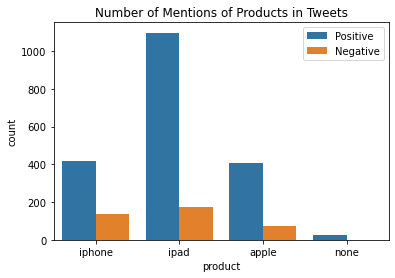

In [1175]:
# Create a count plot

ax = sns.countplot(data=df_apple, x = "product", hue="target_emotion")
ax.legend(['Positive', 'Negative'])
ax.set_title('Number of Mentions of Products in Tweets')
# Show the plot
plt.show()

### Balanced Target Variable

Given the significant imbalance between tweets with positive emotion (majority class) and tweets showing negative emotion (minority class), we'll try undersampling the majority class to balance our data.

In [933]:
#token_docs_df = pd.DataFrame(token_docs)
#token_docs_df.columns = ['tweet_text']
#token_docs_df

In [934]:
# create DataFrame for sampling

train_df = pd.concat([X_train, y_train], axis=1)
train_df

,tweet_text,target_emotion
1573,"RT @mention Hey, you lucky dogs at #SXSW with ...",0
65,I went to #sxswi and all I won was this lousy ...,0
1251,"LOL, I don't see a single PC user around meÛÓ...",0
353,Attending TV + New Media = Formula for Success...,0
700,Download Daily Grape - a new app from @mentio...,0
...,...,...
1638,RT @mention Look everyone! Zomg @mention got a...,0
1095,@mention just got me an iPad from #SXSW Apple ...,0
1130,@mention Last but not least get a copy of Stu...,0
1294,Well having the iPad has really been the perfe...,0


In [935]:
# reduce count of positive emotion to equal that of negative emotion

pos = train_df[train_df['target_emotion'] == 0]
neg = train_df[train_df['target_emotion'] == 1]
pos_undersample = pos.sample(n=len(neg), random_state=42)
train_df_bal = pd.concat([neg, pos_undersample], axis=0)

In [936]:
# sanity check

train_df_bal['target_emotion'].value_counts()

1    323
0    323
Name: target_emotion, dtype: int64

Now we can try our models again with the balanced data.

In [937]:
# Secondary train-test split to build our best model

X_train_bal = train_df_bal['tweet_text']
y_train_bal = train_df_bal['target_emotion']

X_t_bal, X_val_bal, y_t_bal, y_val_bal = train_test_split(X_train_bal,
                                          y_train_bal,
                                          test_size=0.15,
                                          random_state=42)

In [938]:
# use the same count vectorizer - fit_transform on train set, transform on validation set

X_t_bal_cv = cv.fit_transform(X_t_bal)
X_t_bal_cv = pd.DataFrame.sparse.from_spmatrix(X_t_bal_cv)
X_t_bal_cv.columns = sorted(cv.vocabulary_)
X_t_bal_cv.set_index(y_t_bal.index, inplace=True)

X_val_bal_cv = cv.transform(X_val_bal)
X_val_bal_cv = pd.DataFrame.sparse.from_spmatrix(X_val_bal_cv)
X_val_bal_cv.columns = sorted(cv.vocabulary_)
X_val_bal_cv.set_index(y_val_bal.index, inplace=True)

In [939]:
# fit the pipe_mnb pipeline on the balanced train set

pipe_mnb.fit(X_t_bal, y_t_bal)

Pipeline(steps=[('cv',
                 CountVectorizer(stop_words=["isn't", 'wasn', 'at', 'to',
                                             'having', 'once', 'with', 'o',
                                             'has', 'there', 'by', 's', 'below',
                                             'while', 'himself', 'she', 'had',
                                             'why', 'than', 'needn', 'when',
                                             'does', 'from', 'only', 'don',
                                             'doing', 'haven', "couldn't",
                                             'mustn', 'do', ...],
                                 token_pattern="([a-zA-Z]+(?:'[a-z]+)?)")),
                ('mnb', MultinomialNB())])

In [1022]:
# run cross validation

cross_val_score(pipe_mnb, X_t_bal, y_t_bal, cv=10)

array([0.69090909, 0.67272727, 0.54545455, 0.74545455, 0.67272727,
       0.78181818, 0.69090909, 0.76363636, 0.67272727, 0.72222222])

In [940]:
# predict the y validation set

y_hat_bal = pipe_mnb.predict(X_val_bal)

In [1023]:
accuracy_bal = accuracy_score(y_val_bal, y_hat_bal)
classification_rep_bal = classification_report(y_val_bal, y_hat_bal)
conf_matrix_bal = confusion_matrix(y_val_bal, y_hat_bal)

# Print the evaluation metrics
print(f"Accuracy: {accuracy_bal:f}")
print("\nClassification Report:")
print(classification_rep_bal)
print("\nConfusion Matrix:")
print(conf_matrix_bal)

Accuracy: 0.690722

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.84      0.67        37
           1       0.86      0.60      0.71        60

    accuracy                           0.69        97
   macro avg       0.71      0.72      0.69        97
weighted avg       0.75      0.69      0.69        97


Confusion Matrix:
[[31  6]
 [24 36]]


For classifying the negative emotion tweets, balancing the data improved the ...

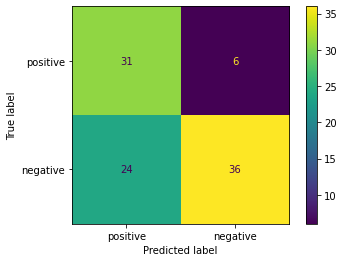

In [942]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_bal, display_labels=['positive', 'negative'])
cm_display.plot()
plt.show()

In [943]:
# fit our GridSearchCV on the balanced training set

gs.fit(X_t_bal, y_t_bal)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(stop_words=["isn't",
                                                                    'wasn',
                                                                    'at', 'to',
                                                                    'having',
                                                                    'once',
                                                                    'with', 'o',
                                                                    'has',
                                                                    'there',
                                                                    'by', 's',
                                                                    'below',
                                                                    'while',
                                                                    'himself',
                                                                    'she',
                                                                    'had',
                                                                    'why',
                                                                    'than',
                                                                    'needn',
                                                                    'when',
                                                                    'does',
                                                                    'from',
                                                                    'only',
                                                                    'don',
                                                                    'doing',
                                                                    'haven',
                                                                    "couldn't",
                                                                    'mustn',
                                                                    'do', ...],
                                                        token_pattern="([a-zA-Z]+(?:'[a-z]+)?)")),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cv__max_features': [10, 15, 20],
                         'cv__ngram_range': [(1, 1), (2, 2), (1, 2)],
                         'mnb__alpha': [0.1, 1, 10]})

In [944]:
gs.best_params_

{'cv__max_features': 20, 'cv__ngram_range': (1, 1), 'mnb__alpha': 1}

In [945]:
gs.cv_results_['mean_test_score'].max()

0.6483838383838384

### Evaluation on Test Set Data

The model providing our best result for its accuracy in predicting the correct type of emotion was the base Multinomial Naive Bayes model with count vectorization.  This model gave us the highest recall score as well, so it is the best at avoiding the identification of a negative tweet as one with positive sentiment.

In [1075]:
X_train_cv = cv.fit_transform(token_docs)


X_train_cv = pd.DataFrame.sparse.from_spmatrix(X_train_cv)
X_train_cv.columns = sorted(cv.vocabulary_)
X_train_cv.set_index(y_train.index, inplace=True)

In [1077]:
best_model = MultinomialNB(alpha=0.1)

best_model.fit(X_train_cv, y_train)
best_model.score(X_train_cv, y_train)

0.980203317281969

In [1078]:
# run the preprocessing function on X_test

token_test = [doc_preparer(doc, sw) for doc in X_test]

In [1079]:
X_test_cv = cv.transform(token_test)

X_test_cv = pd.DataFrame.sparse.from_spmatrix(X_test_cv)
X_test_cv.columns = sorted(cv.vocabulary_)
X_test_cv.set_index(y_test.index, inplace=True)

In [1082]:
y_hat_test = best_model.predict(X_test_cv)

In [1086]:
accuracy_test = accuracy_score(y_test, y_hat_test)
classification_rep_test = classification_report(y_test, y_hat_test)
conf_matrix_test = confusion_matrix(y_test, y_hat_test)

# Print the evaluation metrics
print(f"Accuracy: {accuracy_test:f}")
print("\nClassification Report:")
print(classification_rep_test)
print("\nConfusion Matrix:")
print(conf_matrix_test)

Accuracy: 0.880342

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       403
           1       0.57      0.60      0.58        65

    accuracy                           0.88       468
   macro avg       0.75      0.76      0.76       468
weighted avg       0.88      0.88      0.88       468


Confusion Matrix:
[[373  30]
 [ 26  39]]


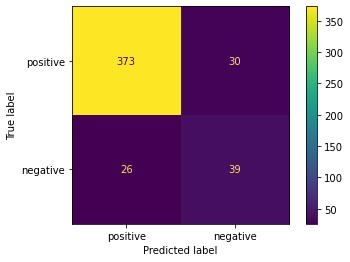

In [1087]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=['positive', 'negative'])
cm_display.plot()
plt.show()